In [37]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx----------CALCULATION OF TWILIGHT TIMES AND NIGHT DURATION---------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #


# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import ephem
import numpy as np
import pandas as pd
import easygui as eg
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DateFormatter, MonthLocator

plt.style.use('bmh')
plt.rc('font', family='sans-serif')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
list_telescopes = 'TelescopeList.dat'

dict_twilights = {'Civil': ['-6', True], 'Nautical': ['-12', True], 'Astronomical': ['-18', True],
                  'Sunset/Sunrise': ['-0.34', False], 'Moonset/Moonrise': ['-0.34', False]}
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Manual Setup - GUI Code
# ------------------------------------------------------------------------------------------------------------------- #
# Telescope Details
telescope = eg.enterbox(msg='Enter The Name of the Telescope', title='Name of the Telescope', default='DOT')
telescope_df = pd.read_csv(list_telescopes, sep='\s+', comment='#').set_index('ShortName')

if telescope in telescope_df.index.values:
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE, _, _) = telescope_df.loc[telescope].values
else:
    telescope = eg.multenterbox('Enter the Necessary Details of the Telescope', title='Details of the Telescope',
                                fields=['Name', 'Longitude', 'Latitude', 'Altitude', 'TimeZone'],
                                values=telescope_df.loc['DOT'].values)
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE) = telescope

# Range of Dates for which Twilight Times have to be calculated
date_start = str(Time(Time.now(), format='iso', out_subfmt='date'))
date_end = str(Time(date_start, format='iso', out_subfmt='date') + 120 * u.d)
daterange = eg.multenterbox('Enter the Time Duration for which the Twilight Times need to be computed',
                            title='Time Duration', fields=['Date Start', 'Date End'], values=[date_start, date_end])

# Choose which columns to be printed to the output file
list_printcols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical', 'DawnNautical',
                  'DawnCivil', 'Sunrise', 'Moonrise', 'Moonset', 'NightDuration', 'MoonIllumination']
printcols = eg.multchoicebox('Choose the Appropriate Columns for the Output file', title='Output Columns',
                             choices=list_printcols, preselect=[2, 5, 10, 11])

# Plot Times in UTC or Local Time?
utc = eg.boolbox(msg='Plot Times in UTC or Local Time?', title='UTC Or Local Time?', choices=['UTC', 'Local Time'])
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Declaring Object 'telescope'
# ------------------------------------------------------------------------------------------------------------------- #
telescope = ephem.Observer()
telescope.pressure = 0
telescope.lon = OBS_LONG
telescope.lat = OBS_LAT
telescope.elevation = OBS_ALT
telescope.epoch = ephem.J2000
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Functions for Calculating Sunset, Sunrise and Twilight Times
# ------------------------------------------------------------------------------------------------------------------- #

def calculate_twilighttime(category='Sunset/Sunrise'):
    """
    It will compute Rising and Setting times for the twilight time specified by 'twilight'.
    Args:
        category : Specifies which Twilight times have to be coomputed
    Returns:
        setting  : Setting time for the twilight
        rising   : Rising time for the twilight
    """
    telescope.horizon = dict_twilights[category][0]
    setting = telescope.previous_setting(ephem.Sun(), use_center=dict_twilights[category][1])
    rising = telescope.next_rising(ephem.Sun(), use_center=dict_twilights[category][1])

    return setting, rising


def calculate_moontime(time_midnight):
    """
    It will compute Moonrise and Moonset times.
    Args:
        time_midnight : Midnight time for the date on which Moonrise and Moonset is to be computed
    Returns:
        rising        : Time of Moonrise
        setting       : Time of Moonset
    """
    category = 'Moonset/Moonrise'
    telescope.horizon = dict_twilights[category][0]

    previousrise = telescope.previous_rising(ephem.Moon(), use_center=dict_twilights[category][1])
    previousset = telescope.previous_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextset = telescope.next_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextrise = telescope.next_rising(ephem.Moon(), use_center=dict_twilights[category][1])

    if previousrise.datetime() > previousset.datetime():
        rising = previousrise
        setting = nextset
    if time_midnight - previousset.datetime() > nextrise.datetime() - time_midnight:
        rising = nextrise
        setting = nextset
    else:
        rising = previousrise
        setting = previousset

    return rising, setting


def get_twilighttimes(time_df, date_obs):
    """
    Obtain Sunset, Sunrise and Twilight times for the observatory on a given date 'date_obs'.
    Args:
        time_df  : Input Pandas DataFrame to which twilight times have to be appended
        date_obs : Date of observation for which twilight times have to be computed
    Returns:
        time_df  : Output Pandas DataFrame to which twilight times have been appended
    """
    time_prevnight = (Time(date_obs) - abs(OBS_TIMEZONE) * u.hour).datetime
    time_midnight = (Time(date_obs) + 1 * u.day - abs(OBS_TIMEZONE) * u.hour).datetime
    telescope.date = time_midnight

    # Calculation Of Local MoonRise & MoonSet [Refraction Correction Of Moon = -0.34 Degrees]
    moon_rise, moon_set = calculate_moontime(time_midnight)

    # Calculation Of Local Sunset & Sunrise [Refractrion Correction for Sun = -0.34 Degrees]
    sun_set, sun_rise = calculate_twilighttime('Sunset/Sunrise')

    # Calculation Of Civil Twilight [Elevation Of Sun = -6 Degrees]
    dusk_civil, dawn_civil = calculate_twilighttime('Civil')

    # Calculation Of Nautical Twilight [Elevation Of Sun = -12 Degrees]
    dusk_nauti, dawn_nauti = calculate_twilighttime('Nautical')

    # Calculation Of Astronomical Twilight [Elevation Of Sun = -18 Degrees]
    dusk_astro, dawn_astro = calculate_twilighttime('Astronomical')

    # Calculation of Maximum Illumination of Moon During the Night
    list_moonphases = []
    for time in np.arange(time_prevnight, time_midnight, timedelta(minutes=15)).astype(datetime):
        time = datetime.strftime(time, '%Y/%m/%d %H:%M:%S')
        list_moonphases.append(ephem.Moon(time).phase)

    nightduration = str(dawn_nauti.datetime() - dusk_nauti.datetime()).split('.')[0]
    moonphase = '{0:.2f}'.format(np.max(list_moonphases))
    
    if utc:
        twilighttimes = [datetime.strftime(time.datetime(), '%H:%M:%S') for time in
                         [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                          dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
    else:
        twilighttimes = [datetime.strftime(time.datetime() + timedelta(hours=OBS_TIMEZONE), '%H:%M:%S')
                         for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]

    dict_columns = {'Sunset': 0, 'DuskCivil': 1, 'DuskNautical': 2, 'DuskAstronomical': 3, 'DawnAstronomical': 4,
                    'DawnNautical': 5, 'DawnCivil': 6, 'Sunrise': 7, 'Moonrise': 8, 'Moonset': 9, 
                    'NightDuration': nightduration, 'MoonIllumination': moonphase}

    for column, index in dict_columns.items():
        date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
        if type(index) == int:
            time_df.loc[date_obs, column] = twilighttimes[index]
        else:
            time_df.loc[date_obs, column] = index

    return time_df

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate the Twilight Times for the Range of Dates
# ------------------------------------------------------------------------------------------------------------------- #
[datestart, dateend] = daterange
localdate_duration = np.arange(Time(datestart), Time(dateend), 3 * u.d)

twilight_df = pd.DataFrame()
plot = pd.DataFrame()
for localdate in localdate_duration:
    twilight_df = get_twilighttimes(twilight_df, localdate)

twilight_df = twilight_df[printcols]
twilight_df.index.name = 'Date'
twilight_df.to_csv('TwilightTimes_{0}To{1}'.format(datestart, dateend), sep='\t')
# ------------------------------------------------------------------------------------------------------------------- #


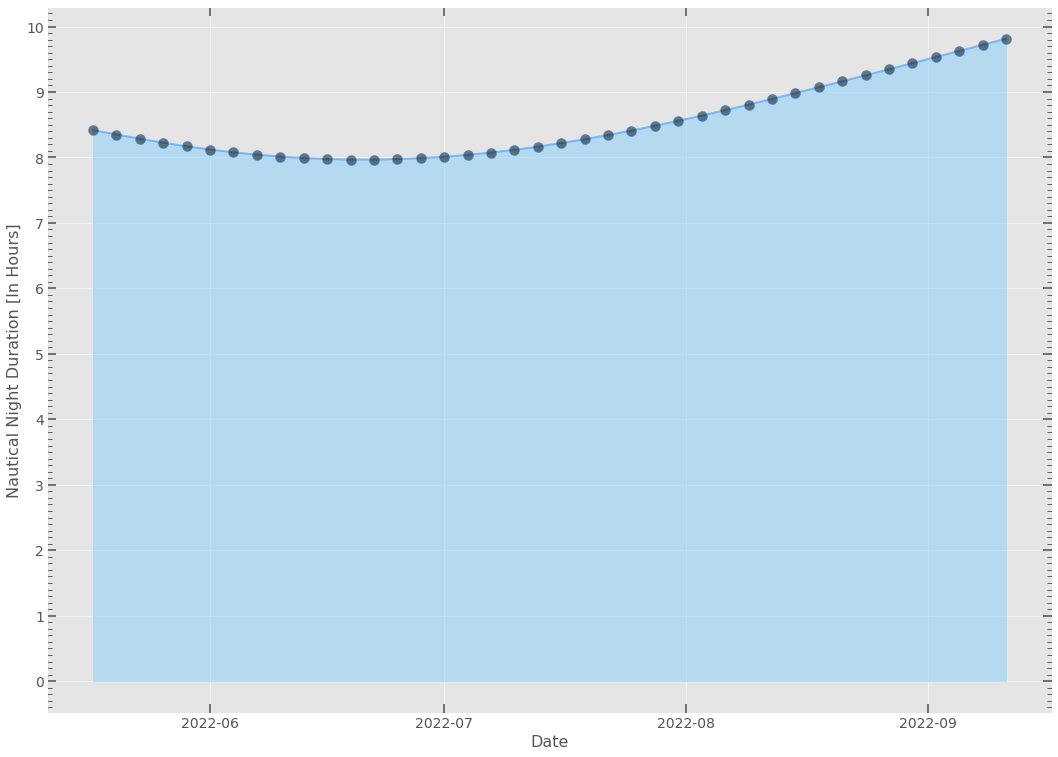

In [34]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot Night Duration as a Function of Date of Observation
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(111)

dates = [datetime.strptime(x, '%Y-%m-%d') for x in twilight_df.index.values]
nightlength = [(datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds() / 3600
               for x in twilight_df['NightDuration']]

ax.plot(dates, nightlength, ls='-', lw=2, marker='o', mfc='k', ms=10, c='dodgerblue', alpha=0.5)
ax.fill_between(dates, nightlength, color='lightskyblue', alpha=0.5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=14)

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Nautical Night Duration [In Hours]', fontsize=16)

# fig.savefig('NightDuration_{0}To{1}.pdf'.format(datestart, dateend), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

In [9]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-------------------------NIGHT SKY PLANNER-------------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #


# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import ephem
import numpy as np
import pandas as pd
import easygui as eg
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Global Variables
# ------------------------------------------------------------------------------------------------------------------- #
list_telescopes = 'TelescopeList.dat'

dict_twilights = {'Civil': ['-6', True], 'Nautical': ['-12', True], 'Astronomical': ['-18', True],
                  'Sunset/Sunrise': ['-0.34', False], 'Moonset/Moonrise': ['-0.34', False]}
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Manual Setup - GUI Code
# ------------------------------------------------------------------------------------------------------------------- #
# Telescope Details
telescope = 'DOT'
daterange = ['2020-11-08', '2021-11-08']
utc = False
printcols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical',
             'DawnNautical', 'DawnCivil', 'Sunrise', 'NightDuration', 'MoonIllumination',
             'Moonrise', 'Moonset']

# telescope = eg.enterbox(msg='Enter The Name of the Telescope', title='Name of the Telescope', default='DOT')
telescope_df = pd.read_csv(list_telescopes, sep='\s+', comment='#').set_index('ShortName')

if telescope in telescope_df.index.values:
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE, _, _) = telescope_df.loc[telescope].values
else:
    telescope = eg.multenterbox('Enter the Site Details of the Telescope [Default = DOT]',
                                title='Details of the Telescope',
                                fields=['Name', 'Longitude', 'Latitude', 'Altitude', 'TimeZone'],
                                values=telescope_df.loc['DOT'].values)
    (OBS_NAME, OBS_LONG, OBS_LAT, OBS_ALT, OBS_TIMEZONE) = telescope

# # Range of Dates for which Twilight Times have to be calculated
# date_start = str(Time(Time.now(), format='iso', out_subfmt='date'))
# date_end = str(Time(date_start, format='iso', out_subfmt='date') + 120 * u.d)
# daterange = eg.multenterbox('Enter the Time Duration for which the Twilight Times need to be computed',
#                             title='Time Duration', fields=['Date Start', 'Date End'], values=[date_start, date_end])

# # Choose which columns to be printed to the output file
# printcols = eg.multchoicebox('Choose the Appropriate Columns for the Output file', title='Output Columns',
#                              choices=['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical',
#                                       'DawnNautical', 'DawnCivil', 'Sunrise', 'NightDuration', 'MoonIllumination',
#                                       'Moonrise', 'Moonset'], preselect=[2, 5, 8, 9])

# # Plot Times in UTC or Local Time?
# utc = eg.boolbox(msg='Plot Times in UTC or Local Time?', title='UTC Or Local Time?', choices=['UTC', 'Local Time'])
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Declaring Object 'telescope'
# ------------------------------------------------------------------------------------------------------------------- #
telescope = ephem.Observer()
telescope.pressure = 0
telescope.lon = OBS_LONG
telescope.lat = OBS_LAT
telescope.elevation = OBS_ALT
telescope.epoch = ephem.J2000
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate Sunset, Sunrise and Twilight Times
# ------------------------------------------------------------------------------------------------------------------- #

def calculate_twilighttime(category='Sunset/Sunrise'):
    """
    It will compute Rising and Setting times for the twilight time specified by 'twilight'.
    Args:
        category : Specifies which Twilight times have to be coomputed
    Returns:
        setting  : Setting time for the twilight
        rising   : Rising time for the twilight
    """
    telescope.horizon = dict_twilights[category][0]
    setting = telescope.previous_setting(ephem.Sun(), use_center=dict_twilights[category][1])
    rising = telescope.next_rising(ephem.Sun(), use_center=dict_twilights[category][1])

    return setting, rising


def calculate_moontime(time_midnight):
    """
    It will compute Moonrise and Moonset times.
    Args:
        time_midnight : Midnight time for the date on which Moonrise and Moonset is to be computed
    Returns:
        rising        : Time of Moonrise
        setting       : Time of Moonset
    """
    category = 'Moonset/Moonrise'
    telescope.horizon = dict_twilights[category][0]

    previousrise = telescope.previous_rising(ephem.Moon(), use_center=dict_twilights[category][1])
    previousset = telescope.previous_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextset = telescope.next_setting(ephem.Moon(), use_center=dict_twilights[category][1])
    nextrise = telescope.next_rising(ephem.Moon(), use_center=dict_twilights[category][1])

    if previousrise.datetime() > previousset.datetime():
        rising = previousrise
        setting = nextset
    if time_midnight - previousset.datetime() > nextrise.datetime() - time_midnight:
        rising = nextrise
        setting = nextset
    else:
        rising = previousrise
        setting = previousset

    return rising, setting


def get_twilighttimes(time_df, date_obs):
    """
    Obtain Sunset, Sunrise and Twilight times for the observatory on a given date 'date_obs'.
    Args:
        time_df  : Input Pandas DataFrame to which twilight times have to be appended
        date_obs : Date of observation for which twilight times have to be computed
    Returns:
        time_df  : Output Pandas DataFrame to which twilight times have been appended
    """
    time_prevnight = (Time(date_obs) - abs(OBS_TIMEZONE) * u.hour).datetime
    time_midnight = (Time(date_obs) + 1 * u.day - abs(OBS_TIMEZONE) * u.hour).datetime
    telescope.date = time_midnight

    # Calculation Of Local MoonRise & MoonSet [Refraction Correction Of Moon = -0.34 Degrees]
    moon_rise, moon_set = calculate_moontime(time_midnight)

    # Calculation Of Local Sunset & Sunrise [Refractrion Correction for Sun = -0.34 Degrees]
    sun_set, sun_rise = calculate_twilighttime('Sunset/Sunrise')

    # Calculation Of Civil Twilight [Elevation Of Sun = -6 Degrees]
    dusk_civil, dawn_civil = calculate_twilighttime('Civil')

    # Calculation Of Nautical Twilight [Elevation Of Sun = -12 Degrees]
    dusk_nauti, dawn_nauti = calculate_twilighttime('Nautical')

    # Calculation Of Astronomical Twilight [Elevation Of Sun = -18 Degrees]
    dusk_astro, dawn_astro = calculate_twilighttime('Astronomical')

    if utc:
        twilighttimes = [datetime.strftime(time.datetime(), '%H:%M:%S') for time in
                         [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                          dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
        plottimes = [time.datetime() for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                                  dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
    else:
        twilighttimes = [datetime.strftime(time.datetime() + timedelta(hours=OBS_TIMEZONE), '%H:%M:%S')
                         for time in [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]
        plottimes = [time.datetime() + timedelta(hours=OBS_TIMEZONE) for time in
                     [sun_set, dusk_civil, dusk_nauti, dusk_astro, dawn_astro,
                      dawn_nauti, dawn_civil, sun_rise, moon_rise, moon_set]]

#     (sunset, duskcivil, dusknauti, duskastro, dawnastro,
#         dawnnauti, dawncivil, sunrise, moonrise, moonset) = twilighttimes

#     plottimes = [datetime.strptime(x - Time(date_obs).datetime, '%d %H:%M:%S') for x in plottimes]
    plottimes = [x - Time(date_obs).datetime for x in plottimes]

    # Calculation of Maximum Illumination of Moon During the Night
    list_moonphases = []
    for time in np.arange(time_prevnight, time_midnight, timedelta(minutes=15)).astype(datetime):
        time = datetime.strftime(time, '%Y/%m/%d %H:%M:%S')
        list_moonphases.append(ephem.Moon(time).phase)

    nightduration = str(dawn_astro.datetime() - dusk_astro.datetime()).split('.')[0]
    moonphase = "{0:.2f}".format(np.max(list_moonphases))

#     dict_columns = {'Sunset': sunset, 'DuskCivil': duskcivil, 'DuskNautical': dusknauti,
#                     'DuskAstronomical': duskastro, 'DawnAstronomical': dawnastro, 'DawnNautical': dawnnauti,
#                     'DawnCivil': dawncivil, 'Sunrise': sunrise, 'NightDuration': nightduration,
#                     'MoonIllumination': moonphase, 'Moonrise': moonrise, 'Moonset': moonset}

#     for column, time in dict_columns.items():
#         date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
#         time_df.loc[date_obs, column] = time
#         if column not in ['MoonIllumination', 'Nightduration']:
#             plot.loc[date_obs, column] = time

    dict_columns = {'Sunset': 0, 'DuskCivil': 1, 'DuskNautical': 2, 'DuskAstronomical': 3, 'DawnAstronomical': 4,
                    'DawnNautical': 5, 'DawnCivil': 6, 'Sunrise': 7, 'Moonrise': 8, 'Moonset': 9, 
                    'NightDuration': nightduration, 'MoonIllumination': moonphase}

    for column, index in dict_columns.items():
        date_obs = str(Time(date_obs, format='iso', out_subfmt='date'))
        if type(index) == int:
            time_df.loc[date_obs, column] = twilighttimes[index]
            plot.loc[date_obs, column] = plottimes[index]
        else:
            time_df.loc[date_obs, column] = index

    return time_df, plot

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculate the Twilight Times for the Range of Dates
# ------------------------------------------------------------------------------------------------------------------- #
[datestart, dateend] = daterange
localdate_duration = np.arange(Time(datestart), Time(dateend), 1 * u.d)

twilight_df = pd.DataFrame()
plot = pd.DataFrame()
for localdate in localdate_duration:
    twilight_df, plot = get_twilighttimes(twilight_df, localdate)

twilight_df = twilight_df[printcols]
twilight_df.index.name = 'Date'
twilight_df.to_csv('TwilightTimes_{0}To{1}'.format(datestart, dateend), sep='\t')
# ------------------------------------------------------------------------------------------------------------------- #

In [11]:
plot

,Sunset,DuskCivil,DuskNautical,DuskAstronomical,DawnAstronomical,DawnNautical,DawnCivil,Sunrise,Moonrise,Moonset
2020-11-08,0 days 17:18:54.546620,0 days 17:44:50.039769,0 days 18:13:14.488350,0 days 18:41:17.838852,1 days 05:09:02.819370,1 days 05:37:08.460955,1 days 06:05:35.667654,1 days 06:31:34.141840,0 days 23:46:01.669968,0 days 12:54:30.318308
2020-11-09,0 days 17:18:17.433567,0 days 17:44:15.764366,0 days 18:12:42.745298,0 days 18:40:48.054274,1 days 05:09:43.054109,1 days 05:37:50.645664,1 days 06:06:20.375588,1 days 06:32:21.679650,1 days 00:49:26.612537,1 days 14:15:55.444310
2020-11-10,0 days 17:17:41.759628,0 days 17:43:42.941861,0 days 18:12:12.474633,0 days 18:40:19.768217,1 days 05:10:23.521583,1 days 05:38:33.086609,1 days 06:07:05.356651,1 days 06:33:09.501626,1 days 01:54:00.078754,1 days 14:53:11.172003
2020-11-11,0 days 17:17:07.546867,0 days 17:43:11.590508,0 days 18:11:43.690587,0 days 18:39:52.990683,1 days 05:11:04.210571,1 days 05:39:15.769514,1 days 06:07:50.592761,1 days 06:33:57.585606,1 days 02:59:37.927444,1 days 15:29:50.508074
2020-11-12,0 days 17:16:34.815611,0 days 17:42:41.726735,0 days 18:11:16.405927,0 days 18:39:27.730974,1 days 05:11:45.109153,1 days 05:39:58.677935,1 days 06:08:36.063036,1 days 06:34:45.906977,1 days 04:06:41.194902,1 days 16:07:21.661542
...,...,...,...,...,...,...,...,...,...,...
2021-11-03,0 days 17:22:31.608151,0 days 17:48:12.605466,0 days 18:16:24.245851,0 days 18:44:17.891184,1 days 05:05:36.139201,1 days 05:33:32.090912,1 days 06:01:46.500288,1 days 06:27:30.480221,1 days 05:32:36.499867,1 days 17:07:24.432236
2021-11-04,0 days 17:21:47.470483,0 days 17:47:31.177688,0 days 18:15:45.192256,0 days 18:43:40.606765,1 days 05:06:15.238418,1 days 05:34:12.960761,1 days 06:02:29.747075,1 days 06:28:16.441893,1 days 06:42:17.696184,1 days 17:48:31.843427
2021-11-05,0 days 17:21:04.631524,0 days 17:46:51.080065,0 days 18:15:07.506418,0 days 18:43:04.733970,1 days 05:06:54.577755,1 days 05:34:54.112258,1 days 06:03:13.311104,1 days 06:29:02.749981,0 days 06:42:17.696193,0 days 17:48:31.843436
2021-11-06,0 days 17:20:23.112168,0 days 17:46:12.330426,0 days 18:14:31.202816,0 days 18:42:30.282817,1 days 05:07:34.148321,1 days 05:35:35.532841,1 days 06:03:57.176003,1 days 06:29:49.384754,0 days 07:54:30.376020,0 days 18:35:35.543887


In [22]:
twilight_df.index

Index(['2020-11-08', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
       '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
       ...
       '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02',
       '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-06', '2021-11-07'],
      dtype='object', name='Date', length=365)

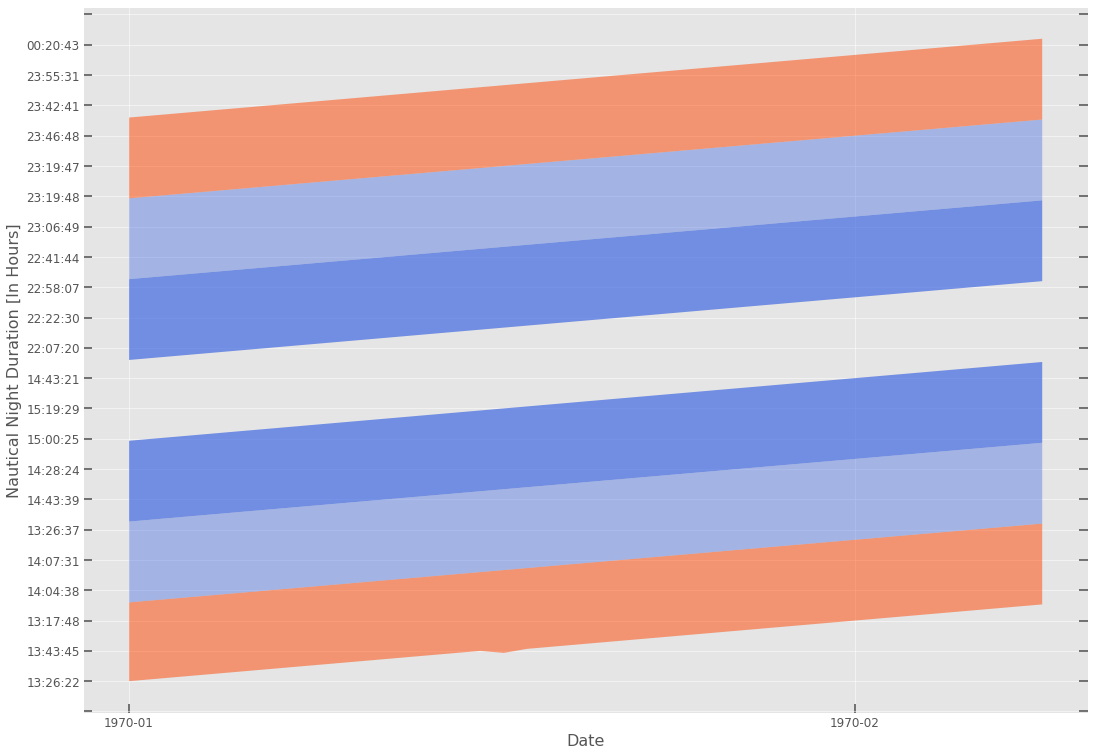

In [46]:
from matplotlib import rc
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FuncFormatter, FormatStrFormatter, MultipleLocator
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator, MonthLocator

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# plt.style.use('bmh')
plt.style.use('ggplot')
plt.rc('font', family='sans-serif')

# ------------------------------------------------------------------------------------------------------------------- #
dates = [datetime.strptime(x, '%Y-%m-%d') for x in plot.index.values]
nightlength = [(datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds() / 3600
               for x in twilight_df['NightDuration']]


# # ax = df.plot.area(stacked=False, color=['#e60000', '#80ccff', '#33adff', '#008ae6'], alpha=0.2)

list_cols = ['Sunset', 'DuskCivil', 'DuskNautical', 'DuskAstronomical', 'DawnAstronomical', 'DawnNautical',
             'DawnCivil', 'Sunrise', 'Moonrise', 'Moonset']


# for cols in list_cols:
#     ax.plot(twilight_df['DateTime'], twilight_df[cols].values, ls='-', marker='*', c='orangered', alpha=0.5)



ax.yaxis_date()

fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(111)

# ax.plot(dates, nightlength, ls='-', lw=2, marker='o', c='orangered', alpha=0.5)

ax.fill_between(twilight_df.index, twilight_df['Sunset'].values, twilight_df['DuskCivil'].values, fc='orangered', alpha=0.5)
ax.fill_between(twilight_df.index, twilight_df['DuskCivil'].values, twilight_df['DuskNautical'].values, fc='royalblue', alpha=0.4)
ax.fill_between(twilight_df.index, twilight_df['DuskNautical'].values, twilight_df['DuskAstronomical'].values, fc='royalblue', alpha=0.7)
# ax.fill_between(twilight_df.index, twilight_df['DuskAstronomical'].values, y2=twilight_df['DawnAstronomical'].values, fc='royalblue', alpha=1)
ax.fill_between(twilight_df.index, twilight_df['DawnAstronomical'].values, y2=twilight_df['DawnNautical'].values, fc='royalblue', alpha=0.7)
ax.fill_between(twilight_df.index, twilight_df['DawnNautical'].values, y2=twilight_df['DawnCivil'].values, fc='royalblue', alpha=0.4)
ax.fill_between(twilight_df.index, twilight_df['DawnCivil'].values, y2=twilight_df['Sunrise'].values, fc='orangered', alpha=0.5)

# ax.set_ylim(np.min(twilight_df['Sunset']), np.max(twilight_df['Sunrise']))
# + np.linspace(time_offset, time_offset + plot_duration, 140) * u.hour
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_major_locator(MultipleLocator(15))
# ax.yaxis.set_minor_locator(MinuteLocator(byminute=15))
# ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=12)
ax.tick_params(axis='both', which='minor', direction='in', width=0.9, length=5, labelsize=12)

ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Nautical Night Duration [In Hours]', fontsize=16)

# ax.set_ylim(18, 24)
# ymajor = MultipleLocator(4)
# yminor = MultipleLocator(1)
# tfmt = FormatStrFormatter('%d:00')
# ax.yaxis.set_major_locator(ymajor)
# ax.yaxis.set_minor_locator(yminor)
# ax.yaxis.set_major_formatter(tfmt)

# ax.autoscale_view()
# fig.autofmt_xdate()
# fig.savefig('TwilightTimes_{0}To{1}.pdf'.format(datestart, dateend), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig)

# ------------------------------------------------------------------------------------------------------------------- #

In [49]:
print (twilight_df['Sunset'].values)

['13:26:22' '13:28:12' '13:29:59' '13:31:44' '13:33:24' '13:35:01'
 '13:36:31' '13:37:56' '13:39:12' '13:40:21' '13:41:21' '13:42:11'
 '13:42:51' '13:43:21' '13:43:39' '13:43:45' '13:43:39' '13:43:20'
 '13:42:48' '13:42:04' '13:41:06' '13:39:56' '13:38:33' '13:36:58'
 '13:35:11' '13:33:13' '13:31:04' '13:28:44' '13:26:13' '13:23:33'
 '13:20:45' '13:17:48' '13:14:44' '13:11:33' '13:08:15' '13:04:53'
 '13:01:25' '12:57:54' '12:54:18' '12:50:40']
